In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-self-attention
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 5.9 MB/s eta 0:00:00


In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.5 MB/s eta 0:00:00


In [5]:
SEED = 61

import os
import re
import gc
import h5py
import torch
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import random as python_random
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk import tokenize
from IPython.display import display_html
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from keras_self_attention import SeqSelfAttention
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from tensorflow.python.keras.layers import Layer, InputSpec, Lambda

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from keras import backend as K
from keras import initializers,regularizers,constraints
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Reshape, Input, Embedding, Flatten, Dense, Dropout, BatchNormalization, Activation #, merge
from keras.layers import TimeDistributed, LSTM, GRU, Bidirectional, Convolution1D, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from keras.layers import RepeatVector #, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model, load_model

def reset_seeds():
    np.random.seed(SEED)
    python_random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)

# from tensorflow.keras import Model
# from attention import Attention_input1, Attention_input2
# from keras.optimizers import SGD, RMSprop, Adagrad

In [20]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')

    feature_names = list(read_file.keys())
    loaded_data = []

    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])
        loaded_data.append((name, dataset))

    return loaded_data

def loadz(path):
    data = np.load(path)['arr_0']
    return data

In [7]:
def load_labels(path):
    data = read_hdf5(path)

    for x in data:
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]

    return labels, text_labels, image_labels

def merge_mvsa(mvsa_single, mvsa_multiple):
    mvsa = np.concatenate((mvsa_single, mvsa_multiple), axis=0)
    return mvsa

def load_mvsa_feature(feature_name, merge=False):
    folder_path = os.path.join('/content/drive/MyDrive/MVSA_features', feature_name)
    single_file = 'mvsa-single-{}.npz'.format(feature_name)
    multiple_file = 'mvsa-multiple-{}.npz'.format(feature_name)
    mvsa_single = loadz(os.path.join(folder_path, single_file))
    mvsa_multiple = loadz(os.path.join(folder_path, multiple_file))

    if merge == True:
        return merge_mvsa(mvsa_single, mvsa_multiple)

    return mvsa_single, mvsa_multiple

In [8]:
def get_features(feature_names):
    mvsa_single_features = []
    mvsa_multiple_features = []

    for name in feature_names:

        name_split = name.split('-')
        textual = name_split[1]
        visual = name_split[0]

        if textual == 'bert':
            textual = 'bert-base'

        textual_features = load_mvsa_feature(textual)
        visual_features = load_mvsa_feature(visual)

        if 'pos' in name and 'ner' not in name:
            temp = []
            pos_features = load_mvsa_feature('pos-tfidf')
            temp.append(np.concatenate((textual_features[0], pos_features[0]), axis=1))
            temp.append(np.concatenate((textual_features[1], pos_features[1]), axis=1))
            textual_features = temp

        elif 'pos' not in name and 'ner' in name:
            temp = []
            ner_features = load_mvsa_feature('ner-tfidf')
            temp.append(np.concatenate((textual_features[0], ner_features[0]), axis=1))
            temp.append(np.concatenate((textual_features[1], ner_features[1]), axis=1))
            textual_features = temp

        elif 'pos' in name and 'ner' in name:
            temp = []
            pos_features = load_mvsa_feature('pos-tfidf')
            ner_features = load_mvsa_feature('ner-tfidf')
            temp.append(np.concatenate((textual_features[0], pos_features[0], ner_features[0]), axis=1))
            temp.append(np.concatenate((textual_features[1], pos_features[1], ner_features[1]), axis=1))
            textual_features = temp

        mvsa_single_features.append([textual_features[0], visual_features[0]])
        mvsa_multiple_features.append([textual_features[1], visual_features[1]])

    return mvsa_single_features, mvsa_multiple_features

In [9]:
# e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
def split_data(data, validation_split):
    num_val = int(validation_split * data.shape[0])
    data_train = data[:-(num_val*2)]
    data_val = data[-(num_val*2):-(num_val)]
    data_test = data[-num_val:]
    return data_train, data_val, data_test

In [10]:
def shuffle_mvsa(mvsa_features, labels, indices):
    shuffled_features = []
#     random_idx = np.random.permutation(len(labels))
    for i in range(len(mvsa_features)):
        x, y = mvsa_features[i][0][indices], mvsa_features[i][1][indices]
        shuffled_features.append([x, y])
    return shuffled_features, labels[indices]

def preprocess_inputs(X1, X2, y, smote):
    y = le.fit_transform(y)
    y = to_categorical(np.asarray(y))

    X1_train, X1_val, X1_test = split_data(X1, VALIDATION_SPLIT)
    X2_train, X2_val, X2_test = split_data(X2, VALIDATION_SPLIT)
    y_train, y_val, y_test = split_data(y, VALIDATION_SPLIT)

    if smote == True:
#         oversample = BorderlineSMOTE(sampling_strategy='minority', random_state=SEED, kind='borderline-2')
        oversample = SMOTE(sampling_strategy='minority', random_state=SEED)
        X1_train, _ = oversample.fit_resample(X1_train, y_train)
        X2_train, y_train = oversample.fit_resample(X2_train, y_train)

    return {'texts': [X1_train, X1_val, X1_test], 'images': [X2_train, X2_val, X2_test], 'labels':[y_train, y_val, y_test]}

# def get_preprocess_input(feature_names, mvsa_features, labels):
#     mvsa_features_shuffled, labels_shuffled = shuffle_mvsa(mvsa_features, labels)
#     mvsa_features_split = []
#     for i in range(len(feature_names)):
#         preprocess_splits = preprocess_inputs(mvsa_features_shuffled[i][0], mvsa_features_shuffled[i][1], labels_shuffled)
#         mvsa_features_split.append(preprocess_splits)
#     return mvsa_features_split

def process_dup(names):
    new_names = []
    for i in range(len(names)):
        count_dup = 0
        for j in range(0, i+1):
            if names[i] == names[j]:
                count_dup += 1
        if count_dup > 1:
            new_names.append(names[i] + '-' + str(count_dup))
        else:
            new_names.append(names[i])
    return new_names

In [11]:
NUM_CLASSES = 3
f1_macro = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', name='f1_macro')
f1_weighted = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='weighted', name='f1_weighted')

def create_model_text(input_shape, lstm=True):
    text_input = Input(shape=input_shape)
    dropout = Dropout(DROPOUT_INPUT) (text_input)
    if lstm == True:
        text_reshape = Reshape((1, -1)) (dropout)
        text_lstm = LSTM(NUM_LSTM) (text_reshape)
        dropout = Dropout(DROPOUT_LSTM) (text_lstm)
    outputs = Dense(NUM_CLASSES, activation='softmax') (dropout)
    model = Model(text_input, outputs)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy', f1_macro, f1_weighted])
    return model

def create_model_image(input_shape, lstm=True):
    image_input = Input(shape=input_shape)
    dropout = Dropout(DROPOUT_INPUT_IMG) (image_input)
#     if lstm == True:
#         image_reshape = Reshape((1, -1)) (dropout)
#         image_lstm = LSTM(NUM_LSTM_IMG) (image_reshape)
#         dropout = Dropout(DROPOUT_LSTM_IMG) (image_lstm)
    outputs = Dense(NUM_CLASSES, activation='softmax') (dropout)
    model = Model(image_input, outputs)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy', f1_macro, f1_weighted])
    return model

def create_model_IF(text_shape, image_shape, lstm=True):
    text_input = Input(shape=text_shape)
    image_input = Input(shape=image_shape)

    text_dropout = Dropout(DROPOUT_INPUT) (text_input)
    image_dropout = Dropout(DROPOUT_INPUT_IMG) (image_input)

    if lstm == True:
        text_reshape = Reshape((1, -1)) (text_dropout)
        text_lstm = LSTM(NUM_LSTM) (text_reshape)
        text_dropout = Dropout(DROPOUT_LSTM) (text_lstm)

#         image_reshape = Reshape((1, -1)) (image_dropout)
#         image_lstm = LSTM(NUM_LSTM_IMG) (image_reshape)
#         image_dropout = Dropout(DROPOUT_LSTM_IMG) (image_lstm)

    text_image_concat = tf.keras.layers.Concatenate(axis=1)([text_dropout, image_dropout])
    concat_reshape = Reshape((1, -1)) (text_image_concat)
    self_attention = SeqSelfAttention() (concat_reshape)
    dropout = Dropout(DROPOUT_ATT) (self_attention)
    flatten = GlobalMaxPooling1D () (self_attention)
    outputs = Dense(NUM_CLASSES, activation='softmax') (flatten)
    model = Model([text_input, image_input], outputs)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy', f1_macro, f1_weighted])
    return model

In [12]:
def weighted_average(weights, probs):
    ''' Calculate the weighted average probability distribution from all input probs and its weights
    weights: weights list (or array)
    probs: probability distributions array list
    '''
    output_probs = []
    weighted_probs = [probs[i] * weights[i] for i in range(len(weights))]
    for i in range(len(probs[0])):
        sum_prob = np.zeros(len(probs[0][0]))
        for j in range(len(weights)):
            sum_prob = np.sum((sum_prob, weighted_probs[j][i]), axis=0)
        output_probs.append(sum_prob)
    return np.asarray(output_probs, dtype='float32')

def get_average_weights(*scores, inverse=False):
    ''' Get the corresponding weight of each input score
    inverse: (bool) get inverse weights value in case of the smaller score value, the bigger weight value (such as model loss)
    '''

    weights = []
    for score in scores:
        weights.append(score/np.sum(scores))

    if inverse == True:
        inverse_weights = []
        inverse = [1/weight for weight in weights]
        for inv in inverse:
            inverse_weights.append(inv/np.sum(inverse))
        weights = inverse_weights

    return weights

In [13]:
def run_and_evaluate_IF(name, X1, X2, y, verbose=0, lstm=True):

    if 'multiple' in name:
        batch_size = BATCH_SIZE_MULTIPLE
        if DO_SMOTE_MULTIPLE == True:
            smote = True
        else:
            smote = False
    else:
        batch_size = BATCH_SIZE_SINGLE # 128
        if DO_SMOTE_SINGLE == True:
            smote = True
        else:
            smote = False

    data = preprocess_inputs(X1, X2, y, smote=smote)
    X1_train, X1_val, X1_test = data['texts']
    X2_train, X2_val, X2_test = data['images']
    y_train, y_val, y_test = data['labels']

    checkpoint_IF_path = './model_checkpoint/{}.h5'.format(name.split('-')[0] + '-' + '-'.join(name.split('-')[2:]))
    history_IF_path = './model_history/{}.npy'.format(name.split('-')[0] + '-' + '-'.join(name.split('-')[2:]))

    if not(os.path.exists(checkpoint_IF_path) and os.path.exists(history_IF_path)):
        print('Create new IF model:', os.path.split(checkpoint_IF_path)[1])

        model_IF = create_model_IF(X1_train.shape[1:], X2_train.shape[1:], lstm=lstm)
        checkpoint_IF = ModelCheckpoint(checkpoint_IF_path, save_best_only=True, verbose=verbose)
        PATIENCE_IF = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=PATIENCE)

        history_IF = model_IF.fit([X1_train, X2_train], y_train, validation_data=([X1_val, X2_val], y_val),
                            epochs=EPOCHS, batch_size=batch_size, verbose=verbose,
                            callbacks=[checkpoint_IF, PATIENCE_IF])
        if not os.path.exists(os.path.split(history_IF_path)[0]):
            os.makedirs(os.path.split(history_IF_path)[0])
        pickle.dump(history_IF.history, open(history_IF_path, 'wb'))

    model_IF = load_model(checkpoint_IF_path, custom_objects={'SeqSelfAttention': SeqSelfAttention})
    history_IF = pickle.load(open(history_IF_path, 'rb'))

    best_epoch = np.argmin(history_IF['val_loss'])
    print('Model IF checkpoint loaded at epoch:', best_epoch)

    return history_IF, evaluate_model_IF(model_IF, X1_test, X2_test, y_test, verbose=verbose)

In [14]:
def run_and_evaluate_LF(name, X1, X2, y, verbose=0, lstm=True):

    if 'multiple' in name:
        batch_size = BATCH_SIZE_MULTIPLE
        if DO_SMOTE_MULTIPLE == True:
            smote = True
        else:
            smote = False
    else:
        batch_size = BATCH_SIZE_SINGLE # 128
        if DO_SMOTE_SINGLE == True:
            smote = True
        else:
            smote = False

    data = preprocess_inputs(X1, X2, y, smote=smote)
    X1_train, X1_val, X1_test = data['texts']
    X2_train, X2_val, X2_test = data['images']
    y_train, y_val, y_test = data['labels']

    PATIENCE_text = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=PATIENCE)
    PATIENCE_image = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=PATIENCE)

    checkpoint_text_path = './model_checkpoint/{}.h5'.format(name.split('-')[0] + '-' + '-'.join(name.split('-')[3:]))
    checkpoint_image_path = './model_checkpoint/{}.h5'.format(name.split('-')[0] + '-' + name.split('-')[2])

    history_text_path = './model_history/{}.npy'.format(name.split('-')[0] + '-' + '-'.join(name.split('-')[3:]))
    history_image_path = './model_history/{}.npy'.format(name.split('-')[0] + '-' + name.split('-')[2])

#     if lstm == True:
#         checkpoint_image_path = './model_checkpoint/{}.h5'.format(name.split('-')[0] + '-' + name.split('-')[2] + '-lstm')
#         history_image_path = './model_history/{}.npy'.format(name.split('-')[0] + '-' + name.split('-')[2] + '-lstm')

    if not (os.path.exists(checkpoint_text_path) and os.path.exists(history_text_path)):
        print('Create new text model:', os.path.split(checkpoint_text_path)[1])

        model_text = create_model_text(X1_train.shape[1:], lstm=lstm)
        checkpoint_text = ModelCheckpoint(checkpoint_text_path, save_best_only=True, verbose=verbose)
        history_text = model_text.fit(X1_train, y_train, validation_data=(X1_val, y_val),
                                  epochs=EPOCHS, batch_size=batch_size, verbose=verbose,
                                  callbacks=[checkpoint_text, PATIENCE_text])
        if not os.path.exists(os.path.split(history_text_path)[0]):
            os.makedirs(os.path.split(history_text_path)[0])
        pickle.dump(history_text.history, open(history_text_path, 'wb'))

    if not(os.path.exists(checkpoint_image_path) and os.path.exists(history_image_path)):
        print('Create new image model:', os.path.split(checkpoint_image_path)[1])

        model_image = create_model_image(X2_train.shape[1:], lstm=lstm)
        checkpoint_image = ModelCheckpoint(checkpoint_image_path,
                                       save_best_only=True, verbose=verbose)
        history_image = model_image.fit(X2_train, y_train, validation_data=(X2_val, y_val),
                                epochs=EPOCHS, batch_size=batch_size, verbose=verbose,
                                callbacks=[checkpoint_image, PATIENCE_image])
        pickle.dump(history_image.history, open(history_image_path, 'wb'))

    model_text = load_model(checkpoint_text_path)
    model_image = load_model(checkpoint_image_path)

    history_text = pickle.load(open(history_text_path, 'rb'))
    history_image = pickle.load(open(history_image_path, 'rb'))

    y_pred_text = model_text.predict(X1_test)
    y_pred_image = model_image.predict(X2_test)

    best_epoch_text = np.argmin(history_text['val_loss'])
    best_epoch_image = np.argmin(history_image['val_loss'])
    print('Model text checkpoint loaded at epoch:', best_epoch_text)
    print('Model image checkpoint loaded at epoch:', best_epoch_image)

    val_acc_text = history_text['val_accuracy'][best_epoch_text]
    val_acc_image = history_image['val_accuracy'][best_epoch_image]
    weights = get_average_weights(val_acc_text, val_acc_image)
    print('Model weights (text, image):', weights)

    y_pred = weighted_average(weights, np.asarray([y_pred_text, y_pred_image], dtype='float32'))

    eval_text = evaluate_model_uni(model_text, X1_test, y_test, verbose=verbose)
    eval_image = evaluate_model_uni(model_image, X2_test, y_test, verbose=verbose)
    eval_LF = evaluate_model_LF(y_test, y_pred, verbose=verbose)
    return eval_text, eval_image, eval_LF

In [15]:
def run_and_evaluate_HF(name, X1, X2, y, verbose=0, lstm=True):

    if 'multiple' in name:
        batch_size = BATCH_SIZE_MULTIPLE
        if DO_SMOTE_MULTIPLE == True:
            smote = True
        else:
            smote = False
    else:
        batch_size = BATCH_SIZE_SINGLE # 128
        if DO_SMOTE_SINGLE == True:
            smote = True
        else:
            smote = False

    data = preprocess_inputs(X1, X2, y, smote=smote)
    X1_train, X1_val, X1_test = data['texts']
    X2_train, X2_val, X2_test = data['images']
    y_train, y_val, y_test = data['labels']

    PATIENCE_text = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=PATIENCE)
    PATIENCE_image = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=PATIENCE)
    PATIENCE_IF = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=PATIENCE)

    checkpoint_text_path = './model_checkpoint/{}.h5'.format(name.split('-')[0] + '-' + '-'.join(name.split('-')[3:]))
    checkpoint_image_path = './model_checkpoint/{}.h5'.format(name.split('-')[0] + '-' + name.split('-')[2])
    checkpoint_IF_path = './model_checkpoint/{}.h5'.format(name.split('-')[0] + '-' + '-'.join(name.split('-')[2:]))

    history_text_path = './model_history/{}.npy'.format(name.split('-')[0] + '-' + '-'.join(name.split('-')[3:]))
    history_image_path = './model_history/{}.npy'.format(name.split('-')[0] + '-' + name.split('-')[2])
    history_IF_path = './model_history/{}.npy'.format(name.split('-')[0] + '-' + '-'.join(name.split('-')[2:]))

#     if lstm == True:
#         checkpoint_image_path = './model_checkpoint/{}.h5'.format(name.split('-')[0] + '-' + name.split('-')[2] + '-lstm')
#         history_image_path = './model_history/{}.npy'.format(name.split('-')[0] + '-' + name.split('-')[2] + '-lstm')

    if not(os.path.exists(checkpoint_text_path) and os.path.exists(history_text_path)):
        print('Create new text model:', os.path.split(checkpoint_text_path)[1])

        model_text = create_model_text(X1_train.shape[1:], lstm=lstm)
        checkpoint_text = ModelCheckpoint(checkpoint_text_path, save_best_only=True, verbose=verbose)
        history_text = model_text.fit(X1_train, y_train, validation_data=(X1_val, y_val),
                                  epochs=EPOCHS, batch_size=batch_size, verbose=verbose,
                                  callbacks=[checkpoint_text, PATIENCE_text])
        if not os.path.exists(os.path.split(history_text_path)[0]):
            os.makedirs(os.path.split(history_text_path)[0])
        pickle.dump(history_text.history, open(history_text_path, 'wb'))

    if not(os.path.exists(checkpoint_image_path) and os.path.exists(history_image_path)):
        print('Create new image model:', os.path.split(checkpoint_image_path)[1])

        model_image = create_model_image(X2_train.shape[1:], lstm=lstm)
        checkpoint_image = ModelCheckpoint(checkpoint_image_path, save_best_only=True, verbose=verbose)
        history_image = model_image.fit(X2_train, y_train, validation_data=(X2_val, y_val),
                                epochs=EPOCHS, batch_size=batch_size, verbose=verbose,
                                callbacks=[checkpoint_image, PATIENCE_image])
        pickle.dump(history_image.history, open(history_image_path, 'wb'))

    if not(os.path.exists(checkpoint_IF_path) and os.path.exists(history_IF_path)):
        print('Create new IF model:', os.path.split(checkpoint_IF_path)[1])

        model_IF = create_model_IF(X1_train.shape[1:], X2_train.shape[1:], lstm=lstm)
        checkpoint_IF = ModelCheckpoint(checkpoint_IF_path, save_best_only=True, verbose=verbose)
        history_IF = model_IF.fit([X1_train, X2_train], y_train, validation_data=([X1_val, X2_val], y_val),
                            epochs=EPOCHS, batch_size=batch_size, verbose=verbose,
                            callbacks=[checkpoint_IF, PATIENCE_IF])
        pickle.dump(history_IF.history, open(history_IF_path, 'wb'))

    model_text = load_model(checkpoint_text_path)
    model_image = load_model(checkpoint_image_path)
    model_IF = load_model(checkpoint_IF_path, custom_objects={'SeqSelfAttention': SeqSelfAttention})

    history_image = pickle.load(open(history_image_path, 'rb'))
    history_text = pickle.load(open(history_text_path, 'rb'))
    history_IF = pickle.load(open(history_IF_path, 'rb'))

    y_pred_text = model_text.predict(X1_test)
    y_pred_image = model_image.predict(X2_test)
    y_pred_IF = model_IF.predict([X1_test, X2_test])

    best_epoch_text = np.argmin(history_text['val_loss'])
    best_epoch_image = np.argmin(history_image['val_loss'])
    best_epoch_IF = np.argmin(history_IF['val_loss'])
    print('Model text checkpoint loaded at epoch:', best_epoch_text)
    print('Model image checkpoint loaded at epoch:', best_epoch_image)
    print('Model IF checkpoint loaded at epoch:', best_epoch_IF)

    val_acc_text = history_text['val_accuracy'][best_epoch_text]
    val_acc_image = history_image['val_accuracy'][best_epoch_image]
    val_acc_IF = history_IF['val_accuracy'][best_epoch_IF]

    weights = get_average_weights(val_acc_text, val_acc_image, val_acc_IF)
    print('Model weights (text, image, IF):', weights)
    y_pred = weighted_average(weights, np.asarray([y_pred_text, y_pred_image, y_pred_IF], dtype='float32'))

    eval_text = evaluate_model_uni(model_text, X1_test, y_test, verbose=verbose)
    eval_image = evaluate_model_uni(model_image, X2_test, y_test, verbose=verbose)
    eval_IF = evaluate_model_IF(model_IF, X1_test, X2_test, y_test, verbose=verbose)
    eval_HF = evaluate_model_LF(y_test, y_pred, verbose=verbose)
    return eval_text, eval_image, eval_IF, eval_HF

In [16]:
def evaluate_model_IF(model, X_texts, X_images, y_test, verbose=1):

    loss, acc, f1_macro, f1_weighted = model.evaluate([X_texts, X_images], y_test, verbose=verbose)

    if verbose == 1:
        print('Loss:', loss)
        print('Accuracy:', acc)
        print('Macro F1-score:', f1_macro)
        print('Weighted F1-score:', f1_weighted)

        y_pred = model.predict([X_texts, X_images])
        matrix = confusion_matrix(le.inverse_transform(y_test.argmax(axis=1)), le.inverse_transform(y_pred.argmax(axis=1)),
                                  labels=list(le.classes_))
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                  display_labels=list(le.classes_))
        cm_disp.plot()
        plt.show()

    return acc, f1_macro, f1_weighted

def evaluate_model_LF(y_true, y_pred, verbose=0):

    y_pred = le.inverse_transform(y_pred.argmax(axis=1))
    y_true = le.inverse_transform(y_true.argmax(axis=1))

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    if verbose == 1:
        print(classification_report(y_true, y_pred))
        matrix = confusion_matrix(y_true, y_pred,
                                  labels=list(le.classes_))
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                  display_labels=list(le.classes_))
        cm_disp.plot()
        plt.show()

    return acc, f1_macro, f1_weighted

def evaluate_model_uni(model, X_test, y_test, verbose=1):

    loss, acc, f1_macro, f1_weighted = model.evaluate(X_test, y_test, verbose=verbose)

    if verbose == 1:
        print('Loss:', loss)
        print('Accuracy:', acc)
        print('Macro F1-score:', f1_macro)
        print('Weighted F1-score:', f1_weighted)

    return acc, f1_macro, f1_weighted

In [17]:
def plot_metrics(history):
    fig = plt.figure(figsize=(20, 5))

    fig.add_subplot(1, 4, 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('LOSS')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 4, 2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('ACCURACY')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 4, 3)
    plt.plot(history['f1_macro'])
    plt.plot(history['val_f1_macro'])
    plt.title('Macro F1-SCORE')
    plt.ylabel('f1-macro')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 4, 4)
    plt.plot(history['f1_weighted'])
    plt.plot(history['val_f1_weighted'])
    plt.title('Weighted F1-SCORE')
    plt.ylabel('f1-weighted')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    plt.show()

In [18]:
def style_dataframe(dataframe):
    return dataframe.style.highlight_max(subset=['Accuracy', 'F1-macro', 'F1-weighted'], props='color:lawngreen', axis=0)\
                          .highlight_min(subset=['Accuracy', 'F1-macro', 'F1-weighted'], props='color:tomato', axis=0)

def highlight_neg(cell):
    if type(cell) != str and cell < 0 :
        return 'color: tomato'
    else:
        return 'color: lawngreen'

def display_dataframes(dfs, names=[], index=False):
    def to_df(x):
        if isinstance(x, pd.Series):
            return pd.DataFrame(x)
        else:
            return x
    html_str = ''
    if names:
        html_str += ('<tr>' +
                     ''.join(f'<td style="text-align:center">{name}</td>' for name in names) +
                     '</tr>')
    html_str += ('<tr>' +
                 ''.join(f'<td style="vertical-align:top"> {to_df(df).to_html()}</td>'
                         for df in dfs) +
                 '</tr>')
    html_str = f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

# Load data

In [21]:
mvsa_single_multimodal_labels, _, _ = load_labels('/content/drive/MyDrive/MVSA_features/labels/mvsa-single-labels.hdf5')
mvsa_multiple_multimodal_labels, _, _ = load_labels('/content/drive/MyDrive/MVSA_features/labels/mvsa-multiple-labels.hdf5')

le = LabelEncoder()
le.fit(mvsa_multiple_multimodal_labels)
NUM_CLASSES = len(le.classes_) # = 3
mapping = dict(zip(range(len(le.classes_)), le.classes_))
print(mapping)

{0: 'negative', 1: 'neutral', 2: 'positive'}


In [23]:
#feature_names = ['resnet101-bert', 'resnet101-bert-lstm', 'densenet201-bert-lstm', 'densenet201-bert-pos-lstm',
#                  'densenet201-bert-ner-lstm',
#                 'densenet201-bert-pos-ner-lstm']

feature_names = ['resnet101-bert', 'resnet101-bert-lstm']
visual_feature_names = process_dup([name.split('-')[0] for name in feature_names])
textual_feature_names = process_dup(['-'.join(name.split('-')[1:]) for name in feature_names])
# for i in range(len(feature_names)):
#     x = ' '.join(feature_names[i].split('-')[1:]).rstrip()
#     if len(x.split()) > 1:
#         x = '-'.join(x.rstrip('-lstm').rstrip().split())
#     textual_feature_names.append(x)

In [24]:
mvsa_single_features, mvsa_multiple_features = get_features(feature_names)

In [ ]:
# Fix random indices for consistency between other experiments
mvsa_single_features, mvsa_single_multimodal_labels = shuffle_mvsa(mvsa_single_features, mvsa_single_multimodal_labels, np.load('../input/mvsa-shuffle-indices/mvsa-single-shuffle-indices.npy'))
mvsa_multiple_features, mvsa_multiple_multimodal_labels = shuffle_mvsa(mvsa_multiple_features, mvsa_multiple_multimodal_labels, np.load('../input/mvsa-shuffle-indices/mvsa-multiple-shuffle-indices.npy'))

In [25]:
reset_seeds()
EPOCHS = 100
VALIDATION_SPLIT = 0.1
PATIENCE = 10
VERBOSE = 1

BATCH_SIZE_SINGLE = 128
BATCH_SIZE_MULTIPLE = 256

DO_SMOTE_SINGLE = True
DO_SMOTE_MULTIPLE = True

NUM_LSTM = 256
DROPOUT_INPUT = 0.0
DROPOUT_LSTM = 0.0

# NUM_LSTM_IMG = 256
DROPOUT_INPUT_IMG = 0.0
# DROPOUT_LSTM_IMG = 0.0

DROPOUT_ATT = 0.0
OPTIMIZER = 'adam'
LOSS = 'categorical_crossentropy'#tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Intermediate Fusion

MVSA-Single with Intermediate Fusion
MVSA-Single: resnet101-bert
Create new IF model: single-resnet101-bert.h5


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.4864 - f1_macro: 0.3863 - f1_weighted: 0.4515
Epoch 1: val_loss improved from inf to 1.10479, saving model to ./model_checkpoint/single-resnet101-bert.h5
42/42 [==============================] - 4s 31ms/step - loss: 1.0478 - accuracy: 0.4864 - f1_macro: 0.3863 - f1_weighted: 0.4515 - val_loss: 1.1048 - val_accuracy: 0.4257 - val_f1_macro: 0.2843 - val_f1_weighted: 0.3942
Epoch 2/100
10/42 [======>.......................] - ETA: 0s - loss: 0.9113 - accuracy: 0.5852 - f1_macro: 0.4918 - f1_weighted: 0.5483

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/42 [==========================>...] - ETA: 0s - loss: 0.8895 - accuracy: 0.5905 - f1_macro: 0.4804 - f1_weighted: 0.5490
Epoch 2: val_loss improved from 1.10479 to 1.04808, saving model to ./model_checkpoint/single-resnet101-bert.h5
42/42 [==============================] - 1s 13ms/step - loss: 0.8872 - accuracy: 0.5919 - f1_macro: 0.4878 - f1_weighted: 0.5532 - val_loss: 1.0481 - val_accuracy: 0.4767 - val_f1_macro: 0.3564 - val_f1_weighted: 0.4751
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.8360 - accuracy: 0.6308 - f1_macro: 0.5574 - f1_weighted: 0.6068
Epoch 3: val_loss did not improve from 1.04808
42/42 [==============================] - 0s 11ms/step - loss: 0.8360 - accuracy: 0.6308 - f1_macro: 0.5574 - f1_weighted: 0.6068 - val_loss: 1.0829 - val_accuracy: 0.4678 - val_f1_macro: 0.3639 - val_f1_weighted: 0.4800
Epoch 4/100
37/42 [=========================>....] - ETA: 0s - loss: 0.8086 - accuracy: 0.6457 - f1_macro: 0.5847 - f1_weighted: 0.6280
Epoch

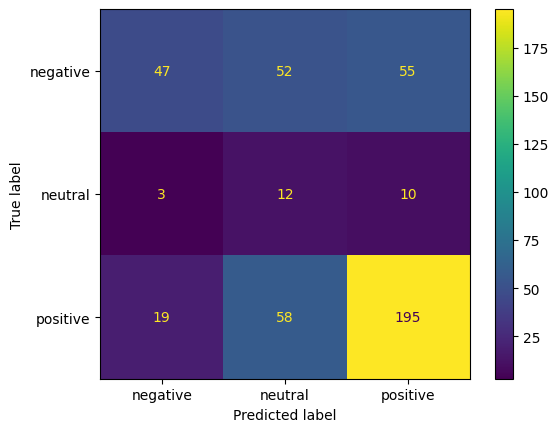


MVSA-Single: resnet101-bert-lstm
Create new IF model: single-resnet101-bert-lstm.h5


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/100
41/42 [============================>.] - ETA: 0s - loss: 1.0099 - accuracy: 0.5198 - f1_macro: 0.4262 - f1_weighted: 0.4847
Epoch 1: val_loss improved from inf to 1.12760, saving model to ./model_checkpoint/single-resnet101-bert-lstm.h5
42/42 [==============================] - 6s 60ms/step - loss: 1.0074 - accuracy: 0.5207 - f1_macro: 0.4264 - f1_weighted: 0.4852 - val_loss: 1.1276 - val_accuracy: 0.4146 - val_f1_macro: 0.2774 - val_f1_weighted: 0.3932
Epoch 2/100
 2/42 [>.............................] - ETA: 2s - loss: 0.8508 - accuracy: 0.6289 - f1_macro: 0.4806 - f1_weighted: 0.5614

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/42 [============================>.] - ETA: 0s - loss: 0.8141 - accuracy: 0.6294 - f1_macro: 0.5266 - f1_weighted: 0.5927
Epoch 2: val_loss improved from 1.12760 to 1.10464, saving model to ./model_checkpoint/single-resnet101-bert-lstm.h5
42/42 [==============================] - 2s 53ms/step - loss: 0.8135 - accuracy: 0.6297 - f1_macro: 0.5290 - f1_weighted: 0.5938 - val_loss: 1.1046 - val_accuracy: 0.4856 - val_f1_macro: 0.3844 - val_f1_weighted: 0.5142
Epoch 3/100
41/42 [============================>.] - ETA: 0s - loss: 0.7231 - accuracy: 0.6877 - f1_macro: 0.6417 - f1_weighted: 0.6780
Epoch 3: val_loss did not improve from 1.10464
42/42 [==============================] - 2s 54ms/step - loss: 0.7238 - accuracy: 0.6872 - f1_macro: 0.6409 - f1_weighted: 0.6777 - val_loss: 1.1328 - val_accuracy: 0.4545 - val_f1_macro: 0.3987 - val_f1_weighted: 0.5268
Epoch 4/100
42/42 [==============================] - ETA: 0s - loss: 0.6701 - accuracy: 0.7131 - f1_macro: 0.6736 - f1_weighted: 0.7060


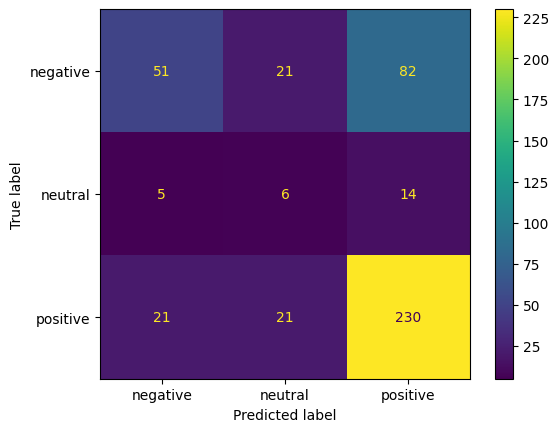


----------------------------------------

MVSA-Multiple with Intermediate Fusion
MVSA-Multiple: resnet101-bert
Create new IF model: multiple-resnet101-bert.h5


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/100
85/85 [==============================] - ETA: 0s - loss: 0.9064 - accuracy: 0.6024 - f1_macro: 0.4580 - f1_weighted: 0.5579
Epoch 1: val_loss improved from inf to 0.81888, saving model to ./model_checkpoint/multiple-resnet101-bert.h5
85/85 [==============================] - 3s 21ms/step - loss: 0.9064 - accuracy: 0.6024 - f1_macro: 0.4580 - f1_weighted: 0.5579 - val_loss: 0.8189 - val_accuracy: 0.6645 - val_f1_macro: 0.3698 - val_f1_weighted: 0.6130
Epoch 2/100
 8/85 [=>............................] - ETA: 1s - loss: 0.8147 - accuracy: 0.6597 - f1_macro: 0.5343 - f1_weighted: 0.6288

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - ETA: 0s - loss: 0.7977 - accuracy: 0.6694 - f1_macro: 0.5316 - f1_weighted: 0.6292
Epoch 2: val_loss did not improve from 0.81888
85/85 [==============================] - 1s 17ms/step - loss: 0.7977 - accuracy: 0.6694 - f1_macro: 0.5316 - f1_weighted: 0.6292 - val_loss: 0.8331 - val_accuracy: 0.6457 - val_f1_macro: 0.3549 - val_f1_weighted: 0.5993
Epoch 3/100
82/85 [===========================>..] - ETA: 0s - loss: 0.7681 - accuracy: 0.6842 - f1_macro: 0.5441 - f1_weighted: 0.6432
Epoch 3: val_loss improved from 0.81888 to 0.81063, saving model to ./model_checkpoint/multiple-resnet101-bert.h5
85/85 [==============================] - 1s 17ms/step - loss: 0.7670 - accuracy: 0.6844 - f1_macro: 0.5442 - f1_weighted: 0.6435 - val_loss: 0.8106 - val_accuracy: 0.6428 - val_f1_macro: 0.3740 - val_f1_weighted: 0.6100
Epoch 4/100
84/85 [============================>.] - ETA: 0s - loss: 0.7511 - accuracy: 0.6916 - f1_macro: 0.5565 - f1_weighted: 0.6533
Epo

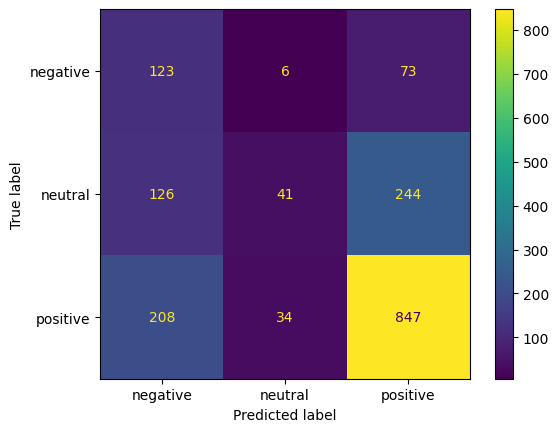


MVSA-Multiple: resnet101-bert-lstm
Create new IF model: multiple-resnet101-bert-lstm.h5


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/100
84/85 [============================>.] - ETA: 0s - loss: 0.8441 - accuracy: 0.6295 - f1_macro: 0.4953 - f1_weighted: 0.5907
Epoch 1: val_loss improved from inf to 0.73782, saving model to ./model_checkpoint/multiple-resnet101-bert-lstm.h5
85/85 [==============================] - 12s 78ms/step - loss: 0.8435 - accuracy: 0.6297 - f1_macro: 0.4958 - f1_weighted: 0.5910 - val_loss: 0.7378 - val_accuracy: 0.6833 - val_f1_macro: 0.4419 - val_f1_weighted: 0.6504
Epoch 2/100
 1/85 [..............................] - ETA: 4s - loss: 0.7377 - accuracy: 0.7031 - f1_macro: 0.6337 - f1_weighted: 0.6925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/85 [============================>.] - ETA: 0s - loss: 0.7278 - accuracy: 0.7011 - f1_macro: 0.5685 - f1_weighted: 0.6647
Epoch 2: val_loss did not improve from 0.73782
85/85 [==============================] - 6s 69ms/step - loss: 0.7276 - accuracy: 0.7012 - f1_macro: 0.5683 - f1_weighted: 0.6647 - val_loss: 0.7551 - val_accuracy: 0.6886 - val_f1_macro: 0.3935 - val_f1_weighted: 0.6243
Epoch 3/100
84/85 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.7170 - f1_macro: 0.5891 - f1_weighted: 0.6833
Epoch 3: val_loss did not improve from 0.73782
85/85 [==============================] - 7s 80ms/step - loss: 0.6905 - accuracy: 0.7170 - f1_macro: 0.5894 - f1_weighted: 0.6832 - val_loss: 0.8428 - val_accuracy: 0.6240 - val_f1_macro: 0.3983 - val_f1_weighted: 0.6201
Epoch 4/100
84/85 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.7272 - f1_macro: 0.6035 - f1_weighted: 0.6957
Epoch 4: val_loss improved from 0.73782 to 0.71302, saving model to ./

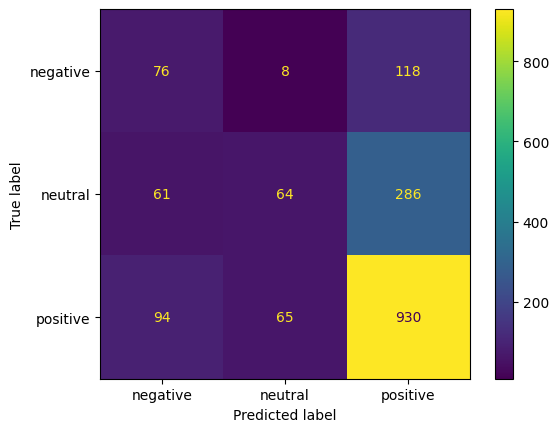

In [26]:
print('MVSA-Single with Intermediate Fusion')
scores = []
for i in range(len(feature_names)):
    print('MVSA-Single:', feature_names[i])
    if 'lstm' in feature_names[i]:
        _, score = run_and_evaluate_IF('single-IF-' + feature_names[i],
                                       mvsa_single_features[i][0],
                                       mvsa_single_features[i][1],
                                       mvsa_single_multimodal_labels,
                                       verbose=VERBOSE, lstm=True)
    else:
        _, score = run_and_evaluate_IF('single-IF-' + feature_names[i],
                                       mvsa_single_features[i][0],
                                       mvsa_single_features[i][1],
                                       mvsa_single_multimodal_labels,
                                       verbose=VERBOSE, lstm=False)
    scores.append(score)
    print()
df0_single_scores_IF = pd.DataFrame(scores, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=feature_names)

print('----------------------------------------')
print('\nMVSA-Multiple with Intermediate Fusion')
scores = []
for i in range(len(feature_names)):
    print('MVSA-Multiple:', feature_names[i])
    if 'lstm' in feature_names[i]:
        _, score = run_and_evaluate_IF('multiple-IF-' + feature_names[i],
                                       mvsa_multiple_features[i][0],
                                       mvsa_multiple_features[i][1],
                                       mvsa_multiple_multimodal_labels,
                                       verbose=VERBOSE, lstm=True)
    else:
        _, score = run_and_evaluate_IF('multiple-IF-' + feature_names[i],
                                       mvsa_multiple_features[i][0],
                                       mvsa_multiple_features[i][1],
                                       mvsa_multiple_multimodal_labels,
                                       verbose=VERBOSE, lstm=False)
    scores.append(score)
    print()
df0_multiple_scores_IF = pd.DataFrame(scores, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=feature_names)

# Late Fusion

MVSA-Single with Late Fusion
MVSA-Single: resnet101-bert
Create new text model: single-bert.h5
Epoch 1/100
23/42 [===============>..............] - ETA: 0s - loss: 1.0204 - accuracy: 0.4725 - f1_macro: 0.4259 - f1_weighted: 0.5249 
Epoch 1: val_loss improved from inf to 1.15420, saving model to ./model_checkpoint/single-bert.h5
42/42 [==============================] - 1s 11ms/step - loss: 0.9880 - accuracy: 0.5074 - f1_macro: 0.4357 - f1_weighted: 0.5197 - val_loss: 1.1542 - val_accuracy: 0.3792 - val_f1_macro: 0.2943 - val_f1_weighted: 0.4043
Epoch 2/100
41/42 [============================>.] - ETA: 0s - loss: 0.8811 - accuracy: 0.5823 - f1_macro: 0.4997 - f1_weighted: 0.5542
Epoch 2: val_loss improved from 1.15420 to 1.12698, saving model to ./model_checkpoint/single-bert.h5
42/42 [==============================] - 0s 4ms/step - loss: 0.8811 - accuracy: 0.5823 - f1_macro: 0.5012 - f1_weighted: 0.5547 - val_loss: 1.1270 - val_accuracy: 0.4169 - val_f1_macro: 0.3563 - val_f1_weighted: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/42 [============================>.] - ETA: 0s - loss: 0.8326 - accuracy: 0.6191 - f1_macro: 0.5568 - f1_weighted: 0.6002
Epoch 3: val_loss improved from 1.12698 to 1.11209, saving model to ./model_checkpoint/single-bert.h5
42/42 [==============================] - 0s 4ms/step - loss: 0.8331 - accuracy: 0.6190 - f1_macro: 0.5568 - f1_weighted: 0.6003 - val_loss: 1.1121 - val_accuracy: 0.4346 - val_f1_macro: 0.3612 - val_f1_weighted: 0.4794
Epoch 4/100
40/42 [===========================>..] - ETA: 0s - loss: 0.8065 - accuracy: 0.6379 - f1_macro: 0.5842 - f1_weighted: 0.6234
Epoch 4: val_loss did not improve from 1.11209
42/42 [==============================] - 0s 4ms/step - loss: 0.8056 - accuracy: 0.6374 - f1_macro: 0.5831 - f1_weighted: 0.6225 - val_loss: 1.2041 - val_accuracy: 0.3659 - val_f1_macro: 0.3089 - val_f1_weighted: 0.4192
Epoch 5/100
24/42 [================>.............] - ETA: 0s - loss: 0.7950 - accuracy: 0.6478 - f1_macro: 0.5941 - f1_weighted: 0.6329
Epoch 5: val_loss

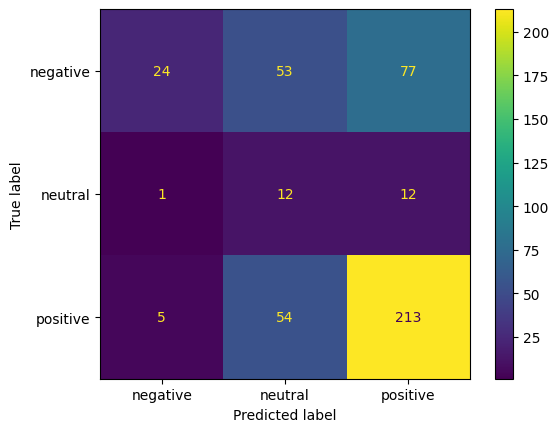


MVSA-Single: resnet101-bert-lstm
Create new text model: single-bert-lstm.h5
Epoch 1/100
41/42 [============================>.] - ETA: 0s - loss: 0.9117 - accuracy: 0.5655 - f1_macro: 0.4583 - f1_weighted: 0.5161
Epoch 1: val_loss improved from inf to 1.05207, saving model to ./model_checkpoint/single-bert-lstm.h5
42/42 [==============================] - 6s 45ms/step - loss: 0.9082 - accuracy: 0.5685 - f1_macro: 0.4621 - f1_weighted: 0.5196 - val_loss: 1.0521 - val_accuracy: 0.4701 - val_f1_macro: 0.3983 - val_f1_weighted: 0.5356
Epoch 2/100
 5/42 [==>...........................] - ETA: 1s - loss: 0.7612 - accuracy: 0.6891 - f1_macro: 0.6570 - f1_weighted: 0.6860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - ETA: 0s - loss: 0.7492 - accuracy: 0.6711 - f1_macro: 0.6280 - f1_weighted: 0.6619
Epoch 2: val_loss did not improve from 1.05207
42/42 [==============================] - 1s 29ms/step - loss: 0.7492 - accuracy: 0.6711 - f1_macro: 0.6280 - f1_weighted: 0.6619 - val_loss: 1.0763 - val_accuracy: 0.5055 - val_f1_macro: 0.4082 - val_f1_weighted: 0.5410
Epoch 3/100
41/42 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.7109 - f1_macro: 0.6737 - f1_weighted: 0.7043
Epoch 3: val_loss did not improve from 1.05207
42/42 [==============================] - 2s 40ms/step - loss: 0.6777 - accuracy: 0.7106 - f1_macro: 0.6731 - f1_weighted: 0.7041 - val_loss: 1.1327 - val_accuracy: 0.4612 - val_f1_macro: 0.3985 - val_f1_weighted: 0.5272
Epoch 4/100
41/42 [============================>.] - ETA: 0s - loss: 0.6400 - accuracy: 0.7268 - f1_macro: 0.6901 - f1_weighted: 0.7203
Epoch 4: val_loss did not improve from 1.05207
42/42 [================

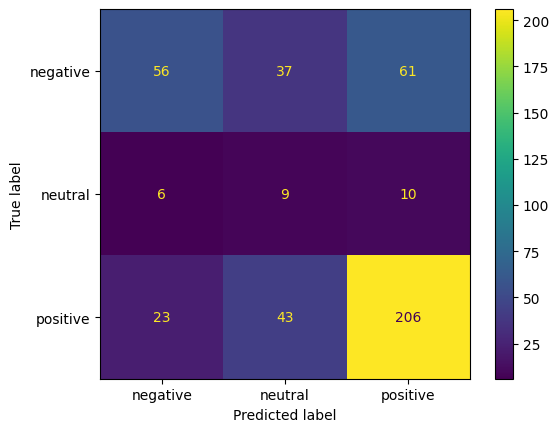


--------------------------------

MVSA-Multiple with Late Fusion
MVSA-Multiple: resnet101-bert
Create new text model: multiple-bert.h5
Epoch 1/100
82/85 [===========================>..] - ETA: 0s - loss: 0.9114 - accuracy: 0.6035 - f1_macro: 0.4565 - f1_weighted: 0.5601
Epoch 1: val_loss improved from inf to 0.83844, saving model to ./model_checkpoint/multiple-bert.h5
85/85 [==============================] - 2s 11ms/step - loss: 0.9098 - accuracy: 0.6037 - f1_macro: 0.4563 - f1_weighted: 0.5598 - val_loss: 0.8384 - val_accuracy: 0.6504 - val_f1_macro: 0.3558 - val_f1_weighted: 0.6011
Epoch 2/100
34/85 [===========>..................] - ETA: 0s - loss: 0.8050 - accuracy: 0.6685 - f1_macro: 0.5185 - f1_weighted: 0.6235

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/85 [============================>.] - ETA: 0s - loss: 0.8015 - accuracy: 0.6691 - f1_macro: 0.5254 - f1_weighted: 0.6261
Epoch 2: val_loss improved from 0.83844 to 0.83367, saving model to ./model_checkpoint/multiple-bert.h5
85/85 [==============================] - 1s 6ms/step - loss: 0.8013 - accuracy: 0.6692 - f1_macro: 0.5255 - f1_weighted: 0.6262 - val_loss: 0.8337 - val_accuracy: 0.6345 - val_f1_macro: 0.3573 - val_f1_weighted: 0.5980
Epoch 3/100
76/85 [=========================>....] - ETA: 0s - loss: 0.7742 - accuracy: 0.6834 - f1_macro: 0.5440 - f1_weighted: 0.6425
Epoch 3: val_loss improved from 0.83367 to 0.80192, saving model to ./model_checkpoint/multiple-bert.h5
85/85 [==============================] - 0s 5ms/step - loss: 0.7723 - accuracy: 0.6841 - f1_macro: 0.5442 - f1_weighted: 0.6435 - val_loss: 0.8019 - val_accuracy: 0.6498 - val_f1_macro: 0.3599 - val_f1_weighted: 0.6009
Epoch 4/100
80/85 [===========================>..] - ETA: 0s - loss: 0.7566 - accuracy: 0.6915

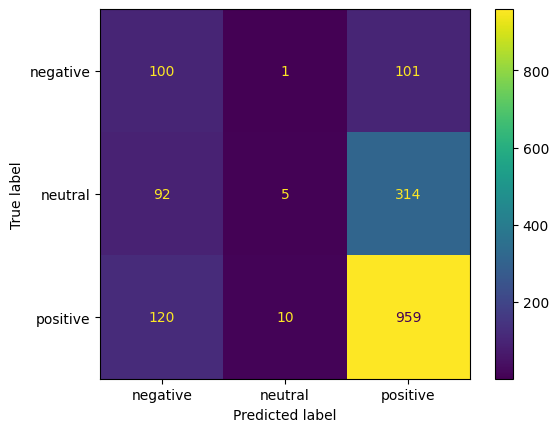


MVSA-Multiple: resnet101-bert-lstm
Create new text model: multiple-bert-lstm.h5
Epoch 1/100
84/85 [============================>.] - ETA: 0s - loss: 0.7969 - accuracy: 0.6708 - f1_macro: 0.4975 - f1_weighted: 0.6005
Epoch 1: val_loss improved from inf to 0.74610, saving model to ./model_checkpoint/multiple-bert-lstm.h5
85/85 [==============================] - 7s 57ms/step - loss: 0.7964 - accuracy: 0.6708 - f1_macro: 0.4978 - f1_weighted: 0.6007 - val_loss: 0.7461 - val_accuracy: 0.6863 - val_f1_macro: 0.4365 - val_f1_weighted: 0.6495
Epoch 2/100
 2/85 [..............................] - ETA: 4s - loss: 0.7249 - accuracy: 0.6934 - f1_macro: 0.5920 - f1_weighted: 0.6758

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/85 [============================>.] - ETA: 0s - loss: 0.7218 - accuracy: 0.7042 - f1_macro: 0.5650 - f1_weighted: 0.6648
Epoch 2: val_loss did not improve from 0.74610
85/85 [==============================] - 5s 63ms/step - loss: 0.7216 - accuracy: 0.7043 - f1_macro: 0.5648 - f1_weighted: 0.6648 - val_loss: 0.7470 - val_accuracy: 0.6880 - val_f1_macro: 0.3893 - val_f1_weighted: 0.6237
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.7194 - f1_macro: 0.5890 - f1_weighted: 0.6843
Epoch 3: val_loss did not improve from 0.74610
85/85 [==============================] - 4s 50ms/step - loss: 0.6869 - accuracy: 0.7194 - f1_macro: 0.5890 - f1_weighted: 0.6843 - val_loss: 0.8346 - val_accuracy: 0.6334 - val_f1_macro: 0.4031 - val_f1_weighted: 0.6234
Epoch 4/100
84/85 [============================>.] - ETA: 0s - loss: 0.6560 - accuracy: 0.7335 - f1_macro: 0.6061 - f1_weighted: 0.7006
Epoch 4: val_loss improved from 0.74610 to 0.71929, saving model to ./

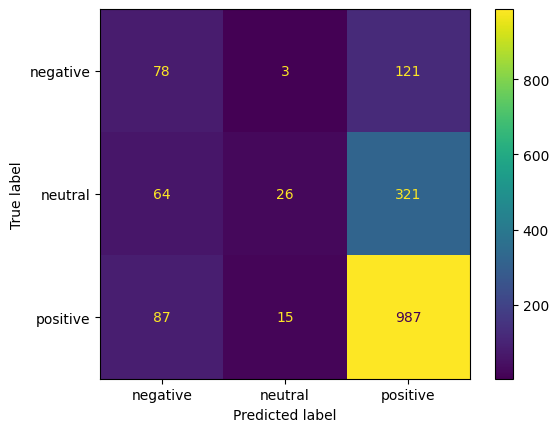

In [27]:
print('MVSA-Single with Late Fusion')
scores_text = []
scores_image = []
scores_LF = []
for i in range(len(feature_names)):
    print('MVSA-Single:', feature_names[i])
    if 'lstm' in feature_names[i]:
        score_text, score_image, score_LF = run_and_evaluate_LF('single-LF-' + feature_names[i],
                                                                mvsa_single_features[i][0],
                                                                mvsa_single_features[i][1],
                                                                mvsa_single_multimodal_labels,
                                                                verbose=VERBOSE, lstm=True)
    else:
        score_text, score_image, score_LF = run_and_evaluate_LF('single-LF-' + feature_names[i],
                                                                mvsa_single_features[i][0],
                                                                mvsa_single_features[i][1],
                                                                mvsa_single_multimodal_labels,
                                                                verbose=VERBOSE, lstm=False)
    scores_text.append(score_text)
    scores_image.append(score_image)
    scores_LF.append(score_LF)
    print()

df1_single_scores_text = pd.DataFrame(scores_text, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=textual_feature_names)
df1_single_scores_image = pd.DataFrame(scores_image, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=visual_feature_names)
df1_single_scores_LF = pd.DataFrame(scores_LF, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=feature_names)

print('--------------------------------')
print('\nMVSA-Multiple with Late Fusion')
scores_text = []
scores_image = []
scores_LF = []
for i in range(len(feature_names)):
    print('MVSA-Multiple:', feature_names[i])
    if 'lstm' in feature_names[i]:
        score_text, score_image, score_LF = run_and_evaluate_LF('multiple-LF-' + feature_names[i],
                                                                mvsa_multiple_features[i][0],
                                                                mvsa_multiple_features[i][1],
                                                                mvsa_multiple_multimodal_labels,
                                                                verbose=VERBOSE, lstm=True)
    else:
        score_text, score_image, score_LF = run_and_evaluate_LF('multiple-LF-' + feature_names[i],
                                                                mvsa_multiple_features[i][0],
                                                                mvsa_multiple_features[i][1],
                                                                mvsa_multiple_multimodal_labels,
                                                                verbose=VERBOSE, lstm=False)
    scores_text.append(score_text)
    scores_image.append(score_image)
    scores_LF.append(score_LF)
    print()

df1_multiple_scores_text = pd.DataFrame(scores_text, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=textual_feature_names)
df1_multiple_scores_image = pd.DataFrame(scores_image, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=visual_feature_names)
df1_multiple_scores_LF = pd.DataFrame(scores_LF, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=feature_names)

# Hybrid Fusion

MVSA-Single with Hybrid Fusion
MVSA-Single: resnet101-bert


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


15/15 [==============================] - 0s 2ms/step
Model text checkpoint loaded at epoch: 10
Model image checkpoint loaded at epoch: 11
Model IF checkpoint loaded at epoch: 12
Model weights (text, image, IF): [0.3187588164092084, 0.32440056000371564, 0.3568406235870759]
15/15 [==============================] - 0s 2ms/step - loss: 1.0363 - accuracy: 0.5122 - f1_macro: 0.4074 - f1_weighted: 0.5656
Loss: 1.0363121032714844
Accuracy: 0.5121951103210449
Macro F1-score: 0.4074249565601349
Weighted F1-score: 0.5656497478485107
15/15 [==============================] - 0s 2ms/step - loss: 1.0310 - accuracy: 0.5366 - f1_macro: 0.2983 - f1_weighted: 0.4484
Loss: 1.0309703350067139
Accuracy: 0.5365853905677795
Macro F1-score: 0.29826387763023376
Weighted F1-score: 0.4483739733695984
15/15 [==============================] - 0s 3ms/step - loss: 0.9662 - accuracy: 0.5632 - f1_macro: 0.4393 - f1_weighted: 0.5951
Loss: 0.9661521315574646
Accuracy: 0.5631929039955139
Macro F1-score: 0.4392908811569214

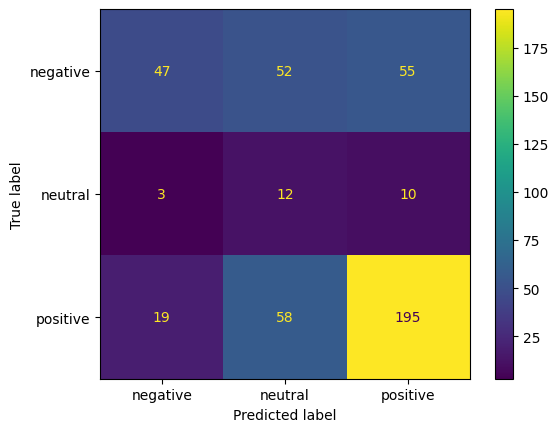

              precision    recall  f1-score   support

    negative       0.76      0.22      0.34       154
     neutral       0.10      0.48      0.16        25
    positive       0.73      0.76      0.74       272

    accuracy                           0.56       451
   macro avg       0.53      0.49      0.42       451
weighted avg       0.70      0.56      0.57       451



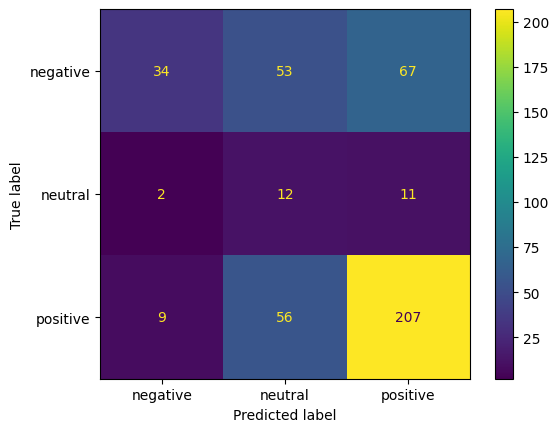


MVSA-Single: resnet101-bert-lstm


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


15/15 [==============================] - 1s 5ms/step
Model text checkpoint loaded at epoch: 7
Model image checkpoint loaded at epoch: 11
Model IF checkpoint loaded at epoch: 14
Model weights (text, image, IF): [0.3238095203263109, 0.31292517653685126, 0.3632653031368379]
15/15 [==============================] - 1s 5ms/step - loss: 0.9921 - accuracy: 0.5920 - f1_macro: 0.4654 - f1_weighted: 0.6268
Loss: 0.9921160340309143
Accuracy: 0.5920177102088928
Macro F1-score: 0.4654030501842499
Weighted F1-score: 0.6267951726913452
15/15 [==============================] - 0s 3ms/step - loss: 1.0310 - accuracy: 0.5366 - f1_macro: 0.2983 - f1_weighted: 0.4484
Loss: 1.0309703350067139
Accuracy: 0.5365853905677795
Macro F1-score: 0.29826387763023376
Weighted F1-score: 0.4483739733695984
15/15 [==============================] - 1s 7ms/step - loss: 0.9449 - accuracy: 0.6364 - f1_macro: 0.4584 - f1_weighted: 0.6238
Loss: 0.9448755979537964
Accuracy: 0.6363636255264282
Macro F1-score: 0.4583909213542938


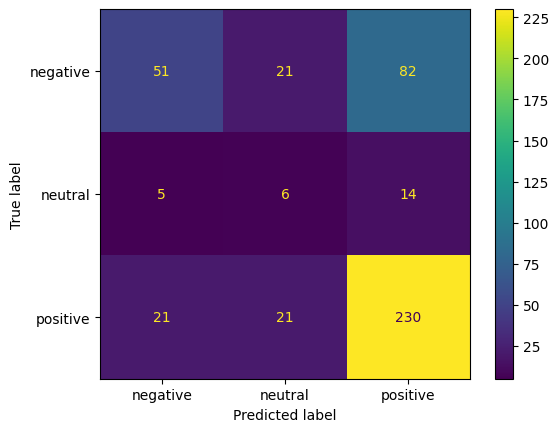

              precision    recall  f1-score   support

    negative       0.66      0.34      0.45       154
     neutral       0.11      0.24      0.15        25
    positive       0.71      0.82      0.76       272

    accuracy                           0.63       451
   macro avg       0.49      0.47      0.45       451
weighted avg       0.66      0.63      0.62       451



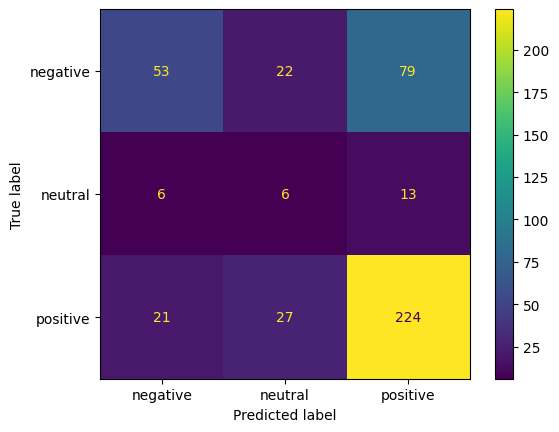


----------------------------------

MVSA-Multiple with Hybrid Fusion
MVSA-Multiple: resnet101-bert


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


54/54 [==============================] - 0s 4ms/step
Model text checkpoint loaded at epoch: 17
Model image checkpoint loaded at epoch: 22
Model IF checkpoint loaded at epoch: 7
Model weights (text, image, IF): [0.3429073889914609, 0.31711606812428794, 0.3399765428842512]
54/54 [==============================] - 0s 3ms/step - loss: 0.8942 - accuracy: 0.6210 - f1_macro: 0.4337 - f1_weighted: 0.5737
Loss: 0.894195020198822
Accuracy: 0.6210340857505798
Macro F1-score: 0.43366917967796326
Weighted F1-score: 0.573733925819397
54/54 [==============================] - 1s 3ms/step - loss: 1.0235 - accuracy: 0.5505 - f1_macro: 0.3133 - f1_weighted: 0.4882
Loss: 1.02353835105896
Accuracy: 0.5505287647247314
Macro F1-score: 0.3133118450641632
Weighted F1-score: 0.4882017970085144
54/54 [==============================] - 1s 4ms/step - loss: 0.9015 - accuracy: 0.5940 - f1_macro: 0.4306 - f1_weighted: 0.5656
Loss: 0.901508629322052
Accuracy: 0.5940070748329163
Macro F1-score: 0.4306153357028961
Weigh

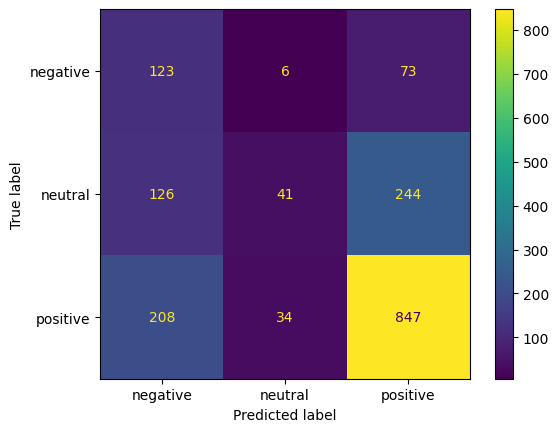

              precision    recall  f1-score   support

    negative       0.32      0.56      0.41       202
     neutral       0.43      0.03      0.06       411
    positive       0.71      0.86      0.77      1089

    accuracy                           0.62      1702
   macro avg       0.49      0.48      0.41      1702
weighted avg       0.60      0.62      0.56      1702



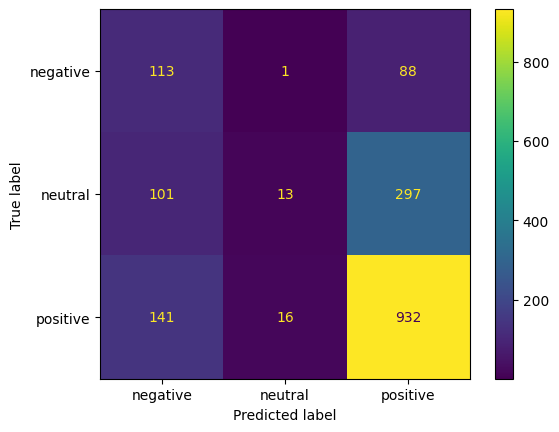


MVSA-Multiple: resnet101-bert-lstm


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


54/54 [==============================] - 1s 6ms/step
Model text checkpoint loaded at epoch: 6
Model image checkpoint loaded at epoch: 22
Model IF checkpoint loaded at epoch: 6
Model weights (text, image, IF): [0.3411697246705805, 0.31020642798869774, 0.34862384734072177]
54/54 [==============================] - 1s 5ms/step - loss: 0.9162 - accuracy: 0.6257 - f1_macro: 0.4572 - f1_weighted: 0.5914
Loss: 0.9161949753761292
Accuracy: 0.6257344484329224
Macro F1-score: 0.457226037979126
Weighted F1-score: 0.591400682926178
54/54 [==============================] - 0s 2ms/step - loss: 1.0235 - accuracy: 0.5505 - f1_macro: 0.3133 - f1_weighted: 0.4882
Loss: 1.02353835105896
Accuracy: 0.5505287647247314
Macro F1-score: 0.3133118450641632
Weighted F1-score: 0.4882017970085144
54/54 [==============================] - 1s 6ms/step - loss: 0.9020 - accuracy: 0.6287 - f1_macro: 0.4508 - f1_weighted: 0.5892
Loss: 0.9020153880119324
Accuracy: 0.6286721229553223
Macro F1-score: 0.4507531225681305
Weigh

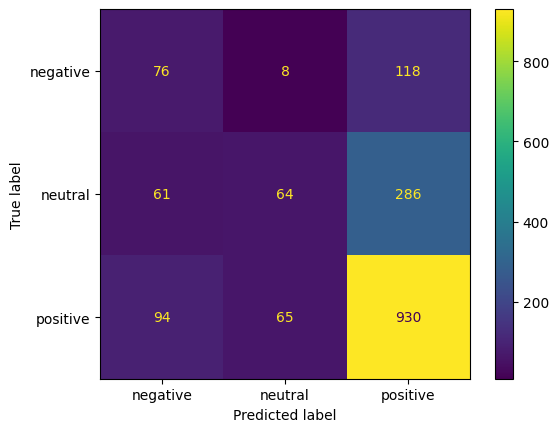

              precision    recall  f1-score   support

    negative       0.33      0.38      0.36       202
     neutral       0.51      0.10      0.16       411
    positive       0.69      0.89      0.78      1089

    accuracy                           0.64      1702
   macro avg       0.51      0.46      0.43      1702
weighted avg       0.61      0.64      0.58      1702



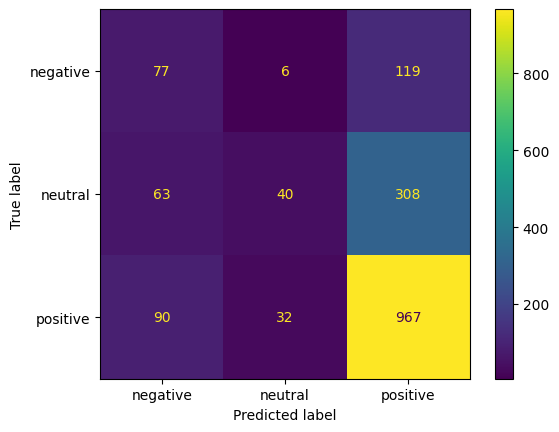

In [28]:
print('MVSA-Single with Hybrid Fusion')
scores_text = []
scores_image = []
scores_IF = []
scores_HF = []
for i in range(len(feature_names)):
    print('MVSA-Single:', feature_names[i])
    if 'lstm' in feature_names[i]:
        score_text, score_image, score_IF, score_HF = run_and_evaluate_HF('single-HF-' + feature_names[i],
                                                                          mvsa_single_features[i][0],
                                                                          mvsa_single_features[i][1],
                                                                          mvsa_single_multimodal_labels,
                                                                          verbose=VERBOSE, lstm=True)
    else:
        score_text, score_image, score_IF, score_HF = run_and_evaluate_HF('single-HF-' + feature_names[i],
                                                                          mvsa_single_features[i][0],
                                                                          mvsa_single_features[i][1],
                                                                          mvsa_single_multimodal_labels,
                                                                          verbose=VERBOSE, lstm=False)
    scores_text.append(score_text)
    scores_image.append(score_image)
    scores_IF.append(score_IF)
    scores_HF.append(score_HF)
    print()

df2_single_scores_text = pd.DataFrame(scores_text, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=textual_feature_names)
df2_single_scores_image = pd.DataFrame(scores_image, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=visual_feature_names)
df2_single_scores_IF = pd.DataFrame(scores_IF, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=feature_names)
df2_single_scores_HF = pd.DataFrame(scores_HF, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=feature_names)

print('----------------------------------')
print('\nMVSA-Multiple with Hybrid Fusion')
scores_text = []
scores_image = []
scores_IF = []
scores_HF = []
for i in range(len(feature_names)):
    print('MVSA-Multiple:', feature_names[i])
    if 'lstm' in feature_names[i]:
        score_text, score_image, score_IF, score_HF = run_and_evaluate_HF('multiple-HF-' + feature_names[i],
                                                                          mvsa_multiple_features[i][0],
                                                                          mvsa_multiple_features[i][1],
                                                                          mvsa_multiple_multimodal_labels,
                                                                          verbose=VERBOSE, lstm=True)
    else:
        score_text, score_image, score_IF, score_HF = run_and_evaluate_HF('multiple-HF-' + feature_names[i],
                                                                          mvsa_multiple_features[i][0],
                                                                          mvsa_multiple_features[i][1],
                                                                          mvsa_multiple_multimodal_labels,
                                                                          verbose=VERBOSE, lstm=False)
    scores_text.append(score_text)
    scores_image.append(score_image)
    scores_IF.append(score_IF)
    scores_HF.append(score_HF)
    print()

df2_multiple_scores_text = pd.DataFrame(scores_text, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=textual_feature_names)
df2_multiple_scores_image = pd.DataFrame(scores_image, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=visual_feature_names)
df2_multiple_scores_IF = pd.DataFrame(scores_IF, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=feature_names)
df2_multiple_scores_HF = pd.DataFrame(scores_HF, columns=['Accuracy', 'F1-macro', 'F1-weighted'], index=feature_names)

# Display results

In [29]:
print('Intermediate Fusion')
display_dataframes((style_dataframe(df0_single_scores_IF), style_dataframe(df0_multiple_scores_IF)),
                   names=['MVSA-Single', 'MVSA-Multiple'])

Intermediate Fusion


MVSA-Single MVSA-Multiple 
 
 
 
   
 Accuracy 
 F1-macro 
 F1-weighted 
 
 
 
 
 resnet101-bert 
 0.563193 
 0.439291 
 0.595111 
 
 
 resnet101-bert-lstm 
 0.636364 
 0.458391 
 0.623815 
 
 
 
 
 
 
 
   
 Accuracy 
 F1-macro 
 F1-weighted 
 
 
 
 
 resnet101-bert 
 0.594007 
 0.430615 
 0.565634 
 
 
 resnet101-bert-lstm 
 0.628672 
 0.450753 
 0.589232

In [30]:
print('LATE FUSION \n')
print('MVSA-Single')
print(display_dataframes((style_dataframe(df1_single_scores_text), style_dataframe(df1_single_scores_image),
                          style_dataframe(df1_single_scores_LF)),
                         names=['Model Text', 'Model Image', 'Model LF']))
print('\nMVSA-Multiple')
print(display_dataframes((style_dataframe(df1_multiple_scores_text), style_dataframe(df1_multiple_scores_image), style_dataframe(df1_multiple_scores_LF)),
                   names=['Model Text', 'Model Image', 'Model LF']))

LATE FUSION 

MVSA-Single


Model Text Model Image Model LF 
 
 
 
   
 Accuracy 
 F1-macro 
 F1-weighted 
 
 
 
 
 bert 
 0.512195 
 0.407425 
 0.565650 
 
 
 bert-lstm 
 0.592018 
 0.465403 
 0.626795 
 
 
 
 
 
 
 
   
 Accuracy 
 F1-macro 
 F1-weighted 
 
 
 
 
 resnet101 
 0.536585 
 0.298264 
 0.448374 
 
 
 resnet101-2 
 0.536585 
 0.298264 
 0.448374 
 
 
 
 
 
 
 
   
 Accuracy 
 F1-macro 
 F1-weighted 
 
 
 
 
 resnet101-bert 
 0.552106 
 0.389899 
 0.545916 
 
 
 resnet101-bert-lstm 
 0.600887 
 0.458990 
 0.621372

None

MVSA-Multiple


Model Text Model Image Model LF 
 
 
 
   
 Accuracy 
 F1-macro 
 F1-weighted 
 
 
 
 
 bert 
 0.621034 
 0.433669 
 0.573734 
 
 
 bert-lstm 
 0.625734 
 0.457226 
 0.591401 
 
 
 
 
 
 
 
   
 Accuracy 
 F1-macro 
 F1-weighted 
 
 
 
 
 resnet101 
 0.550529 
 0.313312 
 0.488202 
 
 
 resnet101-2 
 0.550529 
 0.313312 
 0.488202 
 
 
 
 
 
 
 
   
 Accuracy 
 F1-macro 
 F1-weighted 
 
 
 
 
 resnet101-bert 
 0.625147 
 0.397083 
 0.550092 
 
 
 resnet101-bert-lstm 
 0.641011 
 0.420063 
 0.572158

None


In [31]:
print('HYBRID FUSION \n')
print('MVSA-Single')
print(display_dataframes((style_dataframe(df2_single_scores_text), style_dataframe(df2_single_scores_image),
                          style_dataframe(df2_single_scores_IF), style_dataframe(df2_single_scores_HF)),
                   names=['Model Text', 'Model Image', 'Model IF', 'Model HF']))
print('\nMVSA-Multiple')
print(display_dataframes((style_dataframe(df2_multiple_scores_text), style_dataframe(df2_multiple_scores_image),
                          style_dataframe(df2_multiple_scores_IF), style_dataframe(df2_multiple_scores_HF)),
                   names=['Model Text', 'Model Image', 'Model IF', 'Model HF']))

HYBRID FUSION 

MVSA-Single


Model Text,Model Image,Model IF,Model HF
,Accuracy,F1-macro,F1-weighted
bert,0.512195,0.407425,0.565650
bert-lstm,0.592018,0.465403,0.626795
,Accuracy,F1-macro,F1-weighted
resnet101,0.536585,0.298264,0.448374
resnet101-2,0.536585,0.298264,0.448374
,Accuracy,F1-macro,F1-weighted
resnet101-bert,0.563193,0.439291,0.595111
resnet101-bert-lstm,0.636364,0.458391,0.623815
,Accuracy,F1-macro,F1-weighted


None

MVSA-Multiple


Model Text,Model Image,Model IF,Model HF
,Accuracy,F1-macro,F1-weighted
bert,0.621034,0.433669,0.573734
bert-lstm,0.625734,0.457226,0.591401
,Accuracy,F1-macro,F1-weighted
resnet101,0.550529,0.313312,0.488202
resnet101-2,0.550529,0.313312,0.488202
,Accuracy,F1-macro,F1-weighted
resnet101-bert,0.594007,0.430615,0.565634
resnet101-bert-lstm,0.628672,0.450753,0.589232
,Accuracy,F1-macro,F1-weighted


None


In [32]:
# get max values of late and intermediate fusion
df_single_higher_fusion = pd.DataFrame(np.where(df1_single_scores_LF.gt(df0_single_scores_IF.values),
                                                df1_single_scores_LF.values, df0_single_scores_IF.values),
                                       columns=['Accuracy','F1-macro','F1-weighted'], index=feature_names)

df_multiple_higher_fusion = pd.DataFrame(np.where(df1_multiple_scores_LF.gt(df0_multiple_scores_IF.values),
                                                  df1_multiple_scores_LF.values, df0_multiple_scores_IF.values),
                                         columns=['Accuracy','F1-macro','F1-weighted'], index=feature_names)

df_single_subtract = df2_single_scores_HF.subtract(df_single_higher_fusion)
df_multiple_subtract = df2_multiple_scores_HF.subtract(df_multiple_higher_fusion)

In [33]:
print('Compare Hybrid Fusion with other Fusion Models (>scores)')
display_dataframes((df_single_subtract.style.applymap(highlight_neg), df_multiple_subtract.style.applymap(highlight_neg)),
                   names=['MVSA-Single', 'MVSA-Multiple'])

Compare Hybrid Fusion with other Fusion Models (>scores)


MVSA-Single MVSA-Multiple 
 
 
 
   
 Accuracy 
 F1-macro 
 F1-weighted 
 
 
 
 
 resnet101-bert 
 -0.002217 
 -0.022838 
 -0.021050 
 
 
 resnet101-bert-lstm 
 -0.008869 
 -0.004024 
 -0.001312 
 
 
 
 
 
 
 
   
 Accuracy 
 F1-macro 
 F1-weighted 
 
 
 
 
 resnet101-bert 
 -0.003525 
 -0.017471 
 -0.007542 
 
 
 resnet101-bert-lstm 
 -0.004113 
 -0.017761 
 -0.009052

# Drafts

In [ ]:
# import shutil
# def remove_folder(path):
#     # check if folder exists
#     if os.path.exists(path):
#          # remove if exists
#          shutil.rmtree(path)
#     else:
#          # throw your exception to handle this special scenario
#          raise XXError("your exception")
# remove_folder("./model_checkpoint")
# remove_folder("./model_history")

In [ ]:
# ## Choose best
# # Load text feature
# mvsa_single_bert, mvsa_multiple_bert = load_mvsa_feature('bert-base')
# mvsa_single_pos_bow, mvsa_multiple_pos_bow = load_mvsa_feature('pos-bow')
# mvsa_single_pos_tfidf, mvsa_multiple_pos_tfidf = load_mvsa_feature('pos-tfidf')
# mvsa_single_ner_bow, mvsa_multiple_ner_bow = load_mvsa_feature('ner-bow')
# mvsa_single_ner_tfidf, mvsa_multiple_ner_tfidf = load_mvsa_feature('ner-tfidf')

# ## Load image feature
# mvsa_single_vgg16, mvsa_multiple_vgg16 = load_mvsa_feature('vgg16')
# mvsa_single_vgg19, mvsa_multiple_vgg19 = load_mvsa_feature('vgg19')
# mvsa_single_resnet50, mvsa_multiple_resnet50 = load_mvsa_feature('resnet50')
# mvsa_single_resnet101, mvsa_multiple_resnet101 = load_mvsa_feature('resnet101')
# mvsa_single_resnet152, mvsa_multiple_resnet152 = load_mvsa_feature('resnet152')
# mvsa_single_densenet121, mvsa_multiple_densenet121 = load_mvsa_feature('densenet121')
# mvsa_single_densenet169, mvsa_multiple_densenet169 = load_mvsa_feature('densenet169')
# mvsa_single_densenet201, mvsa_multiple_densenet201 = load_mvsa_feature('densenet201')

# mvsa_single_bert_pos = np.concatenate((mvsa_single_bert, mvsa_single_pos_tfidf), axis=1)
# mvsa_single_bert_ner = np.concatenate((mvsa_single_bert, mvsa_single_ner_tfidf), axis=1)
# mvsa_single_bert_pos_ner = np.concatenate((mvsa_single_bert, mvsa_single_pos_tfidf, mvsa_single_ner_tfidf), axis=1)

# mvsa_multiple_bert_pos = np.concatenate((mvsa_multiple_bert, mvsa_multiple_pos_tfidf), axis=1)
# mvsa_multiple_bert_ner = np.concatenate((mvsa_multiple_bert, mvsa_multiple_ner_tfidf), axis=1)
# mvsa_multiple_bert_pos_ner = np.concatenate((mvsa_multiple_bert, mvsa_multiple_pos_tfidf, mvsa_multiple_ner_tfidf), axis=1)

In [ ]:
# mvsa_single_features_split = get_preprocess_input(feature_names, mvsa_single_features, mvsa_single_multimodal_labels)
# mvsa_multiple_features_split = get_preprocess_input(feature_names, mvsa_multiple_features, mvsa_multiple_multimodal_labels)
# mvsa_single_features, mvsa_single_multimodal_labels = shuffle_mvsa(mvsa_single_features, mvsa_single_multimodal_labels)
# mvsa_multiple_features, mvsa_multiple_multimodal_labels = shuffle_mvsa(mvsa_multiple_features, mvsa_multiple_multimodal_labels)

In [ ]:
# # save shuffle indices for other experiments consistency (temporary fix)
# random_idx_single = np.random.permutation(len(mvsa_single_multimodal_labels))
# random_idx_multiple = np.random.permutation(len(mvsa_multiple_multimodal_labels))
# np.save('mvsa-single-shuffle-indices.npy', random_idx_single)
# np.save('mvsa-multiple-shuffle-indices.npy', random_idx_multiple)

# Plots

In [ ]:
if not os.path.exists('./tables'):
    os.makedirs('./tables')

def style_dataframe_out(dataframe):
    return dataframe.style.highlight_max(subset=['Accuracy', 'F1-weighted'], props='color:lawngreen', axis=0)\
                          .highlight_min(subset=['Accuracy', 'F1-weighted'], props='color:tomato', axis=0)

drop_columns = ['F1-macro']
def dataframe_to_display(df):
    return style_dataframe_out(np.round(df, 3).drop(columns=drop_columns))

In [ ]:
open('./tables/single-IF-scores.html', 'w').write(dataframe_to_display(df0_single_scores_IF).to_html())
open('./tables/single-LF-scores.html', 'w').write(dataframe_to_display(df1_single_scores_LF).to_html())
open('./tables/single-HF-scores.html', 'w').write(dataframe_to_display(df2_single_scores_HF).to_html())

open('./tables/multiple-IF-scores.html', 'w').write(dataframe_to_display(df0_multiple_scores_IF).to_html())
open('./tables/multiple-LF-scores.html', 'w').write(dataframe_to_display(df1_multiple_scores_LF).to_html())
open('./tables/multiple-HF-scores.html', 'w').write(dataframe_to_display(df2_multiple_scores_HF).to_html())

1752

In [ ]:
# import plotly.graph_objects as go
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)

In [ ]:
import plotly.express as px

WIDTH = 650
HEIGHT = 400

if not os.path.exists('./plots'):
    os.makedirs('./plots')

# Num of labels statistics

In [ ]:
len_single_pos = len([x for x in mvsa_single_multimodal_labels if x == 'positive'])
len_single_neu = len([x for x in mvsa_single_multimodal_labels if x == 'neutral'])
len_single_neg = len([x for x in mvsa_single_multimodal_labels if x == 'negative'])

len_multiple_pos = len([x for x in mvsa_multiple_multimodal_labels if x == 'positive'])
len_multiple_neu = len([x for x in mvsa_multiple_multimodal_labels if x == 'neutral'])
len_multiple_neg = len([x for x in mvsa_multiple_multimodal_labels if x == 'negative'])

In [ ]:
len_single_labels = [len_single_pos, len_single_neu, len_single_neg]
len_single_labels = pd.DataFrame(len_single_labels, columns=['samples'])
len_single_labels['Nhãn'] = ['Tích cực', 'Tiêu cực', 'Trung lập']
len_single_labels

fig = px.pie(len_single_labels, values='samples', names='Nhãn', title='Số lượng dữ liệu của từng nhãn MVSA-Single')
fig.update_layout(margin_b=25, margin_t=50, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
fig.update_layout(legend_title='Tập dữ liệu')
fig.write_html('./plots/single-label-plot.html')
fig.show()

# Num label samples pie plots

In [ ]:
x = preprocess_inputs(mvsa_single_features[0][0], mvsa_single_features[0][1], mvsa_single_multimodal_labels, smote=True)['texts']
len_train_single = x[0].shape[0]
len_val_single = x[1].shape[0]
len_test_single = x[2].shape[0]
len_single = [len_train_single, len_val_single, len_test_single]
len_single = pd.DataFrame(len_single, columns=['samples'])
len_single['split'] = ['Train', 'Validation', 'Test']
len_single

,samples,split
0,5382,Train
1,451,Validation
2,451,Test


In [ ]:
x = preprocess_inputs(mvsa_multiple_features[0][0], mvsa_multiple_features[0][1], mvsa_multiple_multimodal_labels, smote=True)['texts']
len_train_multiple = x[0].shape[0]
len_val_multiple = x[1].shape[0]
len_test_multiple = x[2].shape[0]
len_multiple = [len_train_multiple, len_val_multiple, len_test_multiple]
len_multiple = pd.DataFrame(len_multiple, columns=['samples'])
len_multiple['split'] = ['Train', 'Validation', 'Test']
len_multiple

,samples,split
0,21623,Train
1,1702,Validation
2,1702,Test


In [ ]:
fig = px.pie(len_single, values='samples', names='split', title='Biểu đồ số lượng dữ liệu dùng trong tập train, val, test MVSA-Single')
fig.update_layout(margin_b=25, margin_t=50, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
fig.update_layout(legend_title='Tập dữ liệu')
fig.update_traces(textinfo='value')
fig.write_html('./plots/single-pie-plot.html')
fig.show()

In [ ]:
fig = px.pie(len_multiple, values='samples', names='split', title='Biểu đồ số lượng dữ liệu dùng trong tập train, val, test MVSA-Multiple')
fig.update_layout(margin_b=25, margin_t=50, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
fig.update_layout(legend_title='Tập dữ liệu')
fig.update_traces(textinfo='value')
fig.write_html('./plots/multiple-pie-plot.html')
fig.show()

# Fusion and unimodal all in plots

In [ ]:
def get_scores_single(feature, score):
    return df1_single_scores_image.iloc[feature, score], \
            df1_single_scores_text.iloc[feature, score], \
            df1_single_scores_LF.iloc[feature, score], \
            df0_single_scores_IF.iloc[feature, score], \
            df2_single_scores_HF.iloc[feature, score]

def get_scores_multiple(feature, score):
    return df1_multiple_scores_image.iloc[feature, score], \
            df1_multiple_scores_text.iloc[feature, score], \
            df1_multiple_scores_LF.iloc[feature, score], \
            df0_multiple_scores_IF.iloc[feature, score], \
            df2_multiple_scores_HF.iloc[feature, score]

model_names = ['Image', 'Text', 'LF', 'IF', 'HF']

In [ ]:
# MVSA-Single

In [ ]:
df_acc_single = pd.DataFrame(get_scores_single(0, 0), columns=['Score'])
df_acc_single['Model'] = model_names
df_acc_single['Feature'] = feature_names[0]

for i, v in enumerate(feature_names):
    if i == 0:
        continue
    x = pd.DataFrame(get_scores_single(i, 0), columns=['Score'])
    x['Model'] = model_names
    x['Feature'] = v
    df_acc_single = df_acc_single.append(x)

# fig = px.line(df_acc_single, x='Model', y='Score', color='Feature', markers=True)
# fig.update_layout(margin_b=25, margin_t=50, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
# fig.update_layout(title='Biểu đồ so sánh Accuracy giữa các mô hình và đặc trưng MVSA-Single',
#                   legend_title='Đặc trưng', xaxis_title='Mô hình', yaxis_title='Accuracy')
# fig.write_html('./plots/single-acc-plot.html')
# fig.show()

df_f1_single = pd.DataFrame(get_scores_single(0, 2), columns=['Score'])
df_f1_single['Model'] = model_names
df_f1_single['Feature'] = feature_names[0]

for i, v in enumerate(feature_names):
    if i == 0:
        continue
    x = pd.DataFrame(get_scores_single(i, 2), columns=['Score'])
    x['Model'] = model_names
    x['Feature'] = v
    df_f1_single = df_f1_single.append(x)

# fig = px.line(df_f1_single, x='Model', y='Score', color='Feature', markers=True)
# fig.update_layout(margin_b=25, margin_t=50, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
# fig.update_layout(legend_title='Đặc trưng', xaxis_title='Mô hình', yaxis_title='F1-weighted')
# fig.write_html('./plots/single-f1-plot.html')
# fig.show()

df_acc_single['score_name'] = 'Accuracy'
df_f1_single['score_name'] = 'F1-weighted'
df_score_single = df_acc_single.append(df_f1_single)

In [ ]:
fig = px.line(df_score_single, x="Model", y="Score",\
              facet_col="score_name",\
              facet_col_spacing = 0.15, color='Feature', markers=True)
fig.update_layout(barmode='group')
fig.update_layout(margin_b=25, margin_t=100, margin_l=25, margin_r=25, width=WIDTH+50, height=HEIGHT+50)
fig.update_layout(title='Biểu đồ Accuracy, F1-score so sánh giữa các mô hình và đặc trưng <br>trong bộ dữ liệu MVSA-Single',
                  legend_title='Features', xaxis_title='Model')
fig.write_html('./plots/single-scores-plot.html')
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.25,
    xanchor="left",
    x=0.35
))
fig.show()

In [ ]:
# MVSA-Multiple

In [ ]:
df_acc_multiple = pd.DataFrame(get_scores_multiple(0, 0), columns=['Score'])
df_acc_multiple['Model'] = model_names
df_acc_multiple['Feature'] = feature_names[0]

for i, v in enumerate(feature_names):
    if i == 0:
        continue
    x = pd.DataFrame(get_scores_multiple(i, 0), columns=['Score'])
    x['Model'] = model_names
    x['Feature'] = v
    df_acc_multiple = df_acc_multiple.append(x)

# fig = px.line(df_acc_multiple, x='Model', y='Score', color='Feature', markers=True)
# fig.update_layout(margin_b=25, margin_t=50, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
# fig.update_layout(legend_title='Đặc trưng', xaxis_title='Mô hình')
# fig.write_html('./plots/multiple-acc-plot.html')
# fig.show()

df_f1_multiple = pd.DataFrame(get_scores_multiple(0, 2), columns=['Score'])
df_f1_multiple['Model'] = model_names
df_f1_multiple['Feature'] = feature_names[0]

for i, v in enumerate(feature_names):
    if i == 0:
        continue
    x = pd.DataFrame(get_scores_multiple(i, 2), columns=['Score'])
    x['Model'] = model_names
    x['Feature'] = v
    df_f1_multiple = df_f1_multiple.append(x)

# fig = px.line(df_f1_multiple, x='Model', y='Score', color='Feature', markers=True)
# fig.update_layout(margin_b=25, margin_t=50, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
# fig.update_layout(legend_title='Đặc trưng', xaxis_title='Mô hình')
# fig.write_html('./plots/multiple-f1-plot.html')
# fig.show()

df_acc_multiple['score_name'] = 'Accuracy'
df_f1_multiple['score_name'] = 'F1-weighted'
df_score_multiple = df_acc_multiple.append(df_f1_multiple)

In [ ]:
fig = px.line(df_score_multiple, x="Model", y="Score",\
              facet_col="score_name",\
              facet_col_spacing = 0.15, color='Feature', markers=True)
fig.update_layout(barmode='group')
fig.update_layout(margin_b=25, margin_t=100, margin_l=25, margin_r=25, width=WIDTH+50, height=HEIGHT+50)
fig.update_layout(title='Biểu đồ Accuracy, F1-score so sánh giữa các mô hình và đặc trưng <br>trong bộ dữ liệu MVSA-Multiple',
                  legend_title='Features', xaxis_title='Model')
fig.write_html('./plots/multiple-scores-plot.html')
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.25,
    xanchor="left",
    x=0.35
))
fig.show()

# DenseNet201-BERT-LSTM plot

In [ ]:
pp_single = pd.DataFrame(get_scores_single(2, 0), columns=['Accuracy'])
pp_single['F1-weighted'] = get_scores_single(2, 2)
pp_single.index = model_names
open('./tables/single-densenet201-bert-lstm-scores.html', 'w').write(style_dataframe_out(pp_single).to_html())
style_dataframe_out(pp_single)

,Accuracy,F1-weighted
Image,0.623060,0.624288
Text,0.623060,0.632316
LF,0.698448,0.698357
IF,0.720621,0.720188
HF,0.722838,0.721405


In [ ]:
pp_multiple = pd.DataFrame(get_scores_multiple(2, 0), columns=['Accuracy'])
pp_multiple['F1-weighted'] = get_scores_multiple(2, 2)
pp_multiple.index = model_names
open('./tables/multiple-densenet201-bert-lstm-scores.html', 'w').write(style_dataframe_out(pp_multiple).to_html())
style_dataframe_out(pp_multiple)

,Accuracy,F1-weighted
Image,0.575793,0.565953
Text,0.667450,0.633233
LF,0.673913,0.624978
IF,0.678026,0.648520
HF,0.676263,0.633991


In [ ]:
pp_multiple1 = pd.DataFrame(get_scores_multiple(3, 0), columns=['Accuracy'])
pp_multiple1['F1-weighted'] = get_scores_multiple(3, 2)
pp_multiple1.index = model_names
open('./tables/multiple-densenet201-bert-pos-lstm-scores.html', 'w').write(style_dataframe_out(pp_multiple1).to_html())
style_dataframe_out(pp_multiple1)

,Accuracy,F1-weighted
Image,0.575793,0.565953
Text,0.659812,0.627428
LF,0.669800,0.622267
IF,0.678613,0.655695
HF,0.676263,0.639022


# Text plots


In [ ]:
df1_single_scores_text

,Accuracy,F1-macro,F1-weighted
bert,0.611973,0.525230,0.627419
bert-lstm,0.623060,0.535537,0.632316
bert-lstm-2,0.623060,0.535537,0.632316
bert-pos-lstm,0.631929,0.536335,0.636701
bert-pos-ner-lstm,0.620843,0.532161,0.634997


In [ ]:
df_single = df1_single_scores_text.drop(df1_single_scores_text.index[0], axis=0).drop(df1_single_scores_text.index[2], axis=0).drop(columns=['F1-macro'])
df_single = pd.DataFrame(np.array([[0.501109, 0.433083]]), columns=['Accuracy', 'F1-weighted'], index=['glove']).append(df_single)
df_single['Đặc trưng'] = df_single.index
df_single['Bộ dữ liệu'] = 'MVSA-Single'

In [ ]:
df_multiple = df1_multiple_scores_text.drop(df1_multiple_scores_text.index[0], axis=0).drop(df1_multiple_scores_text.index[2], axis=0).drop(columns=['F1-macro'])
df_multiple = pd.DataFrame(np.array([[0.453584, 0.454950]]), columns=['Accuracy', 'F1-weighted'], index=['glove']).append(df_multiple)
df_multiple['Đặc trưng'] = df_multiple.index
df_multiple['Bộ dữ liệu'] = 'MVSA-Multiple'

In [ ]:
df = pd.concat([df_single, df_multiple])

In [ ]:
fig = px.bar(df, x="Đặc trưng", y=["Accuracy", "F1-weighted"], facet_col="Bộ dữ liệu", facet_col_spacing = 0.15)
fig.update_layout(barmode = 'group')
# fig.update_layout(bargap=0.2)
fig.update_layout(margin_b=25, margin_t=50, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
fig.update_layout(title='Biểu đồ kết quả đánh giá các đặc trưng của dữ liệu văn bản',
              yaxis_title='Điểm', legend_title='Độ đo')
fig.write_html('./plots/text-scores-plot.html')
fig.show()